In [ ]:
"""
story:
let's assume we have a LIDAR
https://www.nuscenes.org/data-annotation
https://level5.lyft.com/dataset/#data-format

WE have a lidar and a detector which should detect pedestrian/traffic signs/and free space
the detector was built by someone else and we do not know anything about its quality, but we want to (and have to) use this in practice.

We want to make the best out of it using repeated measurements.

It is imporant that we asusme that these measurements are completely independent form each other...which is not ture, but we will deal with this in practice later.

"""

import numpy as np
import gdown

## LIDAR Model

In [ ]:
"""
class Model():
  #this is a  simple probabilistic model representing our sensor
  def __init__ (self):
    #constructor

  def GenerateState(self):
    #this function generates a random hidden state
    #has no return value

  def GetState(self):
    #this is a function we can not use inn practice, it reveals the hidden state. We will use this to check our result.
    #returns a number, the index of the hidden state (0,1,2)

  def Measure(self):
    #this funciton makes a measuerement with a previously set hidden state
    #returns the index of the measured state (0,1,2)

  def MeasureKnownState(self,X):
    #this function makes a measurement with a known hidden state
    #the hidden state is the imnput aprametre of the function (0,1,2)
    #returns the index of the measured state (0,1,2)
"""

url = 'https://drive.google.com/uc?id=1mi9WvjTDscb3VZe1Hdg-Iv02DwXYJNR0'
output = 'LIDARModel.py'
gdown.download(url, output, quiet=False)
import LIDARModel as Model

Downloading...
From (original): https://drive.google.com/uc?id=1mi9WvjTDscb3VZe1Hdg-Iv02DwXYJNR0
From (redirected): https://drive.google.com/uc?id=1mi9WvjTDscb3VZe1Hdg-Iv02DwXYJNR0&confirm=t&uuid=5d8d83e5-5975-4a60-a031-31713d7d7648
To: /content/LIDARModel.py
100%|██████████| 1.09k/1.09k [00:00<00:00, 2.89MB/s]


In [ ]:
M = Model.Model() #initalize this model
M.GenerateState() #generate a random hidden state

M.GetState()      #we can check the hidden state...!this is not a measurement

2

In [ ]:
#let's make 10 measurements with the known hidden states
for i in range(10):
  print(M.Measure())

1
2
2
1
2
2
2
1
2
2


In [ ]:
repeat = 1000
state_count=np.zeros(3)
for i in range(repeat):
  measurement=M.Measure()
  state_count[measurement]+=1

print(state_count)
state_count/=repeat
print(state_count)


[ 98.  87. 815.]
[0.098 0.087 0.815]


In [ ]:
repeat = 10000

#RelFreqMat how many times we measure each state
RelativeFrequencyMatrix= np.zeros((3,3))

for hidden_state in range(3):
  for i in range(repeat):
    act_observation = M.MeasureKnownState(hidden_state)

    # RelativeFrequencyMatrix[STATE, Observation]
    RelativeFrequencyMatrix[hidden_state,act_observation]+=1
print(RelativeFrequencyMatrix)


[[5021. 1997. 2982.]
 [2926. 6043. 1031.]
 [1027. 1012. 7961.]]


In [ ]:
#How many times I get a given observation /what is the probability of each observed class
ObservationProbability = np.sum(RelativeFrequencyMatrix,0)
ObservationProbability = np.sum(RelativeFrequencyMatrix,0)/np.sum(RelativeFrequencyMatrix)
print("ObservationProbability",ObservationProbability)

# What is the probability of being in a state, if I got an observation ### wrong?
print(np.sum(RelativeFrequencyMatrix,0))
ObservationMatrix = RelativeFrequencyMatrix/np.sum(RelativeFrequencyMatrix,0) # row-wise summation instead?
print("ObservationMatrix\n",ObservationMatrix)

ObservationProbability [0.29913333 0.30173333 0.39913333]
[ 8974.  9052. 11974.]
ObservationMatrix
 [[0.55950524 0.22061423 0.24903959]
 [0.32605304 0.66758727 0.08610322]
 [0.11444172 0.1117985  0.66485719]]


In [ ]:
# Bayesia estimate for the actual measurement (repeated measurements)

"""
P(A|B)= (P(B|A)*P(A))/P(B)
P(hidden|measurment) = (P(measurement|hidden)*P(hidden))/P(measurement,observation)
P(B|A) Observation Matrix
P(A): prior assumption: what we know  about the hidden state

? What is th probability of a hidden state A, if we know the observation B ?
"""
M.GenerateState()
print("Hidden state: ",M.GetState())

repeat = 10
prior_assumption = np.array([1/3,1/3,1/3])
#I make multiple measurements
for i in range(repeat):
  measurement = M.Measure()
  # print(measurement)
  # print(ObservationMatrix[:,measurement])# what is the probability of the hidden states, if I got my measurement
  prediction = (ObservationMatrix[:,measurement]*prior_assumption)/ObservationProbability
  #do normalization
  prediction = prediction/np.sum(prediction)
  print(prediction)
  prior_assumption = prediction


Hidden state:  2
[0.29908096 0.10251356 0.59840548]
[0.19528413 0.0229431  0.78177277]
[0.11049668 0.00444966 0.88505366]
[5.86858648e-02 8.10034830e-04 9.40504100e-01]
[3.02389483e-02 1.43063687e-04 9.69617988e-01]
[1.53472770e-02 2.48878057e-05 9.84627835e-01]
[7.73001613e-03 4.29663264e-06 9.92265687e-01]
[3.87844508e-03 7.38921009e-07 9.96120816e-01]
[1.94220233e-03 1.26831575e-07 9.98057671e-01]
[9.71649969e-04 2.17488001e-08 9.99028328e-01]


In [ ]:
# Entropy calculation
# -E(log(x))

def Entropy(p):
  E=0
  for prob in p:
    if prob!=0:
      E+=-prob*np.log(prob)
  return E

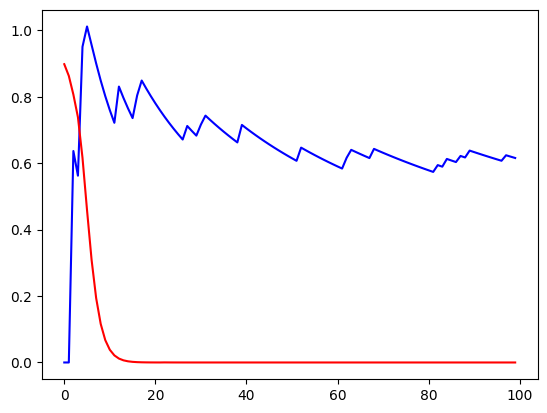

In [ ]:
import matplotlib.pyplot as plt

repeat = 100
state_count=np.zeros(3)
AvgEntropy = np.zeros(repeat)
for i in range(repeat):
  measurement=M.Measure()
  state_count[measurement]+=1
  prob=state_count/(i+1)
  AvgEntropy[i] = Entropy(prob)
plt.plot(AvgEntropy, 'b', label = 'Average entropy')


prior_assumption = np.array([1/3,1/3,1/3])
BayesianEntropy=np.zeros(repeat)
for i in range(repeat):
  measurement = M.Measure()
  prediction = (ObservationMatrix[:,measurement]*prior_assumption)/ObservationProbability
  prediction = prediction/np.sum(prediction)
  prior_assumption = prediction
  BayesianEntropy[i]=Entropy(prediction)

plt.plot(BayesianEntropy,'r',label="Bayesian entropy")
plt.show()

